In [1]:

%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from FRVRS import (fu, nu, nan, DataFrame, Series)
import matplotlib.pyplot as plt
import pandas as pd
import os
import string


# Recompute Poster Visualizations

In [3]:

# Get all CSVs out of one data frame
frvrs_logs_df = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df')['frvrs_logs_df']
print(frvrs_logs_df.shape) # (829277, 114)

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
(829116, 114)


In [ ]:

# Create the tag-to-SALT data frame
tag_to_salt_df = fu.get_is_tag_correct_dataframe(frvrs_logs_df, groupby_column='logger_version')


----


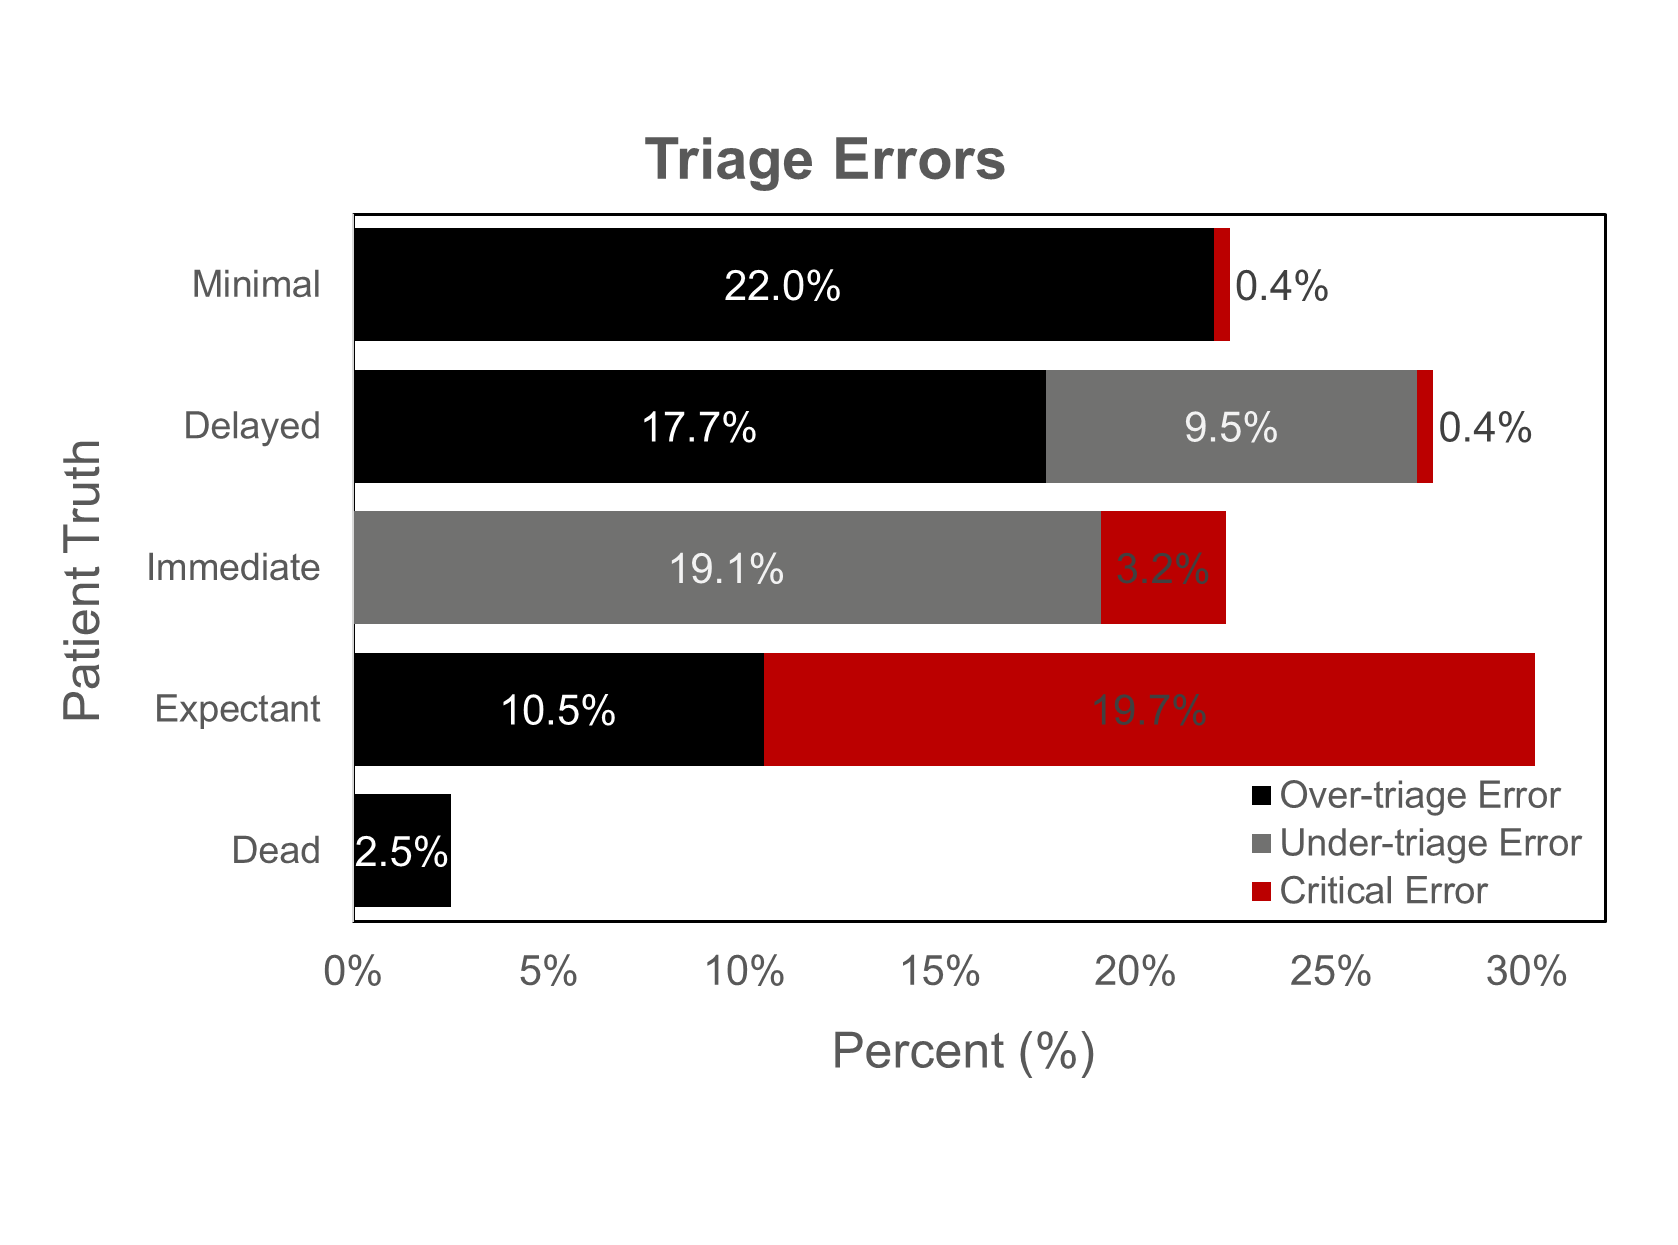

In [9]:

mask_series = (tag_to_salt_df.scene_type == 'Triage') & (tag_to_salt_df.is_scene_aborted == False)
mask_series &= (tag_to_salt_df.is_a_one_triage_file == True)
# mask_series &= (tag_to_salt_df.last_tag != 'Not Tagged') & ~tag_to_salt_df.last_tag.isnull() & ~tag_to_salt_df.max_salt.isnull()
groupby_columns = ['last_tag', 'max_salt']
ERROR_TYPE_DF = tag_to_salt_df[mask_series].groupby(groupby_columns).patient_count.sum().to_frame()
ERROR_TYPE_DF = ERROR_TYPE_DF.reset_index()

# Remove "Not Tagged" from consideration
def f(df):
    if df.last_tag in fu.error_table_df.index: error_type = fu.error_table_df[fu.error_table_df.index == df.last_tag][df.max_salt].squeeze()
    else: error_type = nan

    return error_type
ERROR_TYPE_DF['error_type'] = ERROR_TYPE_DF.apply(f, axis='columns')

# Convert the columns to the custom categorical type
ERROR_TYPE_DF['last_tag'] = ERROR_TYPE_DF['last_tag'].astype(fu.colors_category_order)
ERROR_TYPE_DF['max_salt'] = ERROR_TYPE_DF['max_salt'].astype(fu.salt_category_order)
ERROR_TYPE_DF['error_type'] = ERROR_TYPE_DF['error_type'].astype(fu.errors_category_order)

# Sort the Data Frame based on the custom categorical orders
ERROR_TYPE_DF = ERROR_TYPE_DF.sort_values(by=groupby_columns+['error_type'])

In [10]:

suffixing_fn = lambda x: f'{x}-triage Error' if (x in ['Over', 'Under']) else (f'{x} Error' if (x in ['Critical']) else x)

In [11]:

def show_stacked_horizontal_bar_chart(column_name, ylabel=''):
    unique_categories = ERROR_TYPE_DF[column_name].unique()
    over_values, under_values, critical_values = [], [], []
    for i, column_value in enumerate(unique_categories):
        mask_series = (ERROR_TYPE_DF[column_name] == column_value)
        df = ERROR_TYPE_DF[mask_series].groupby('error_type').patient_count.sum().reset_index()
        total_patient_count = df.patient_count.sum()
        error_dict = df.set_index('error_type').patient_count.to_dict()
        
        over_patient_count = error_dict.get('Over', 0)
        over_values.append(100*over_patient_count/total_patient_count)
        
        under_patient_count = error_dict.get('Under', 0)
        under_values.append(100*under_patient_count/total_patient_count)
        
        critical_patient_count = error_dict.get('Critical', 0)
        critical_values.append(100*critical_patient_count/total_patient_count)
    
    # Create a horizontal bar chart for the first set of values
    over_bar = plt.barh(unique_categories, over_values, color='#000000', label=suffixing_fn('Over'))
    
    # Create a stacked horizontal bar chart for the second set of values
    under_bar = plt.barh(unique_categories, under_values, color='#717170', label=suffixing_fn('Under'), left=over_values)
    
    # Create a stacked horizontal bar chart for the third set of values
    critical_bar = plt.barh(
        unique_categories, critical_values, color='#bb0000', label=suffixing_fn('Critical'), left=[v1 + v2 for v1, v2 in zip(over_values, under_values)]
    )
    
    # Annotate the values of each value set inside their respective rectangles
    for bars, values in zip([over_bar, under_bar, critical_bar], [over_values, under_values, critical_values]):
        for bar, value in zip(bars, values):
            if (bar.get_facecolor() == (0.7333333333333333, 0.0, 0.0, 1.0)):
                if (value >= 2.0): plt.text(
                    bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='#404040'
                )
                elif (value > 0): plt.text(
                    bar.get_x() + bar.get_width() + 1.2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='black'
                )
            else:
                if (value >= 2.0): plt.text(
                    bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='white'
                )
                elif (value > 0): plt.text(
                    bar.get_x() + bar.get_width() + 1.2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='black'
                )
    
    # Set the title, labels, legend, and grid
    plt.title('Triage Errors')
    plt.xlabel('Percent (%)')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(False)
    
    # Remove x-axis and y-axis ticks
    plt.xticks([])
    plt.yticks([])
    
    # Get the current x-axis tick locations and labels
    xticks = plt.xticks()[0]
    xticklabels = [f'{label:.1f}%' for label in xticks]
    
    # Set the new x-axis tick labels with "%"
    plt.xticks(xticks, xticklabels)
    
    # Display the chart
    plt.show()

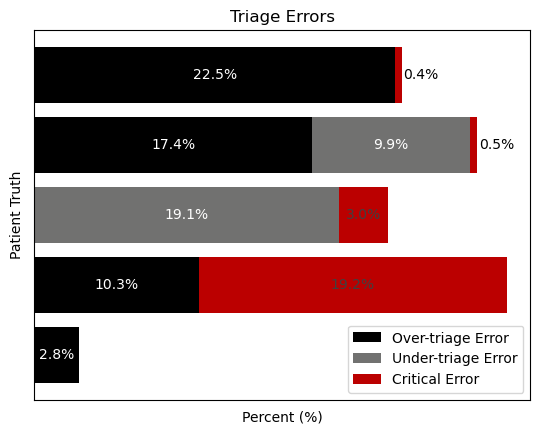

In [12]:

show_stacked_horizontal_bar_chart('max_salt', ylabel='Patient Truth')


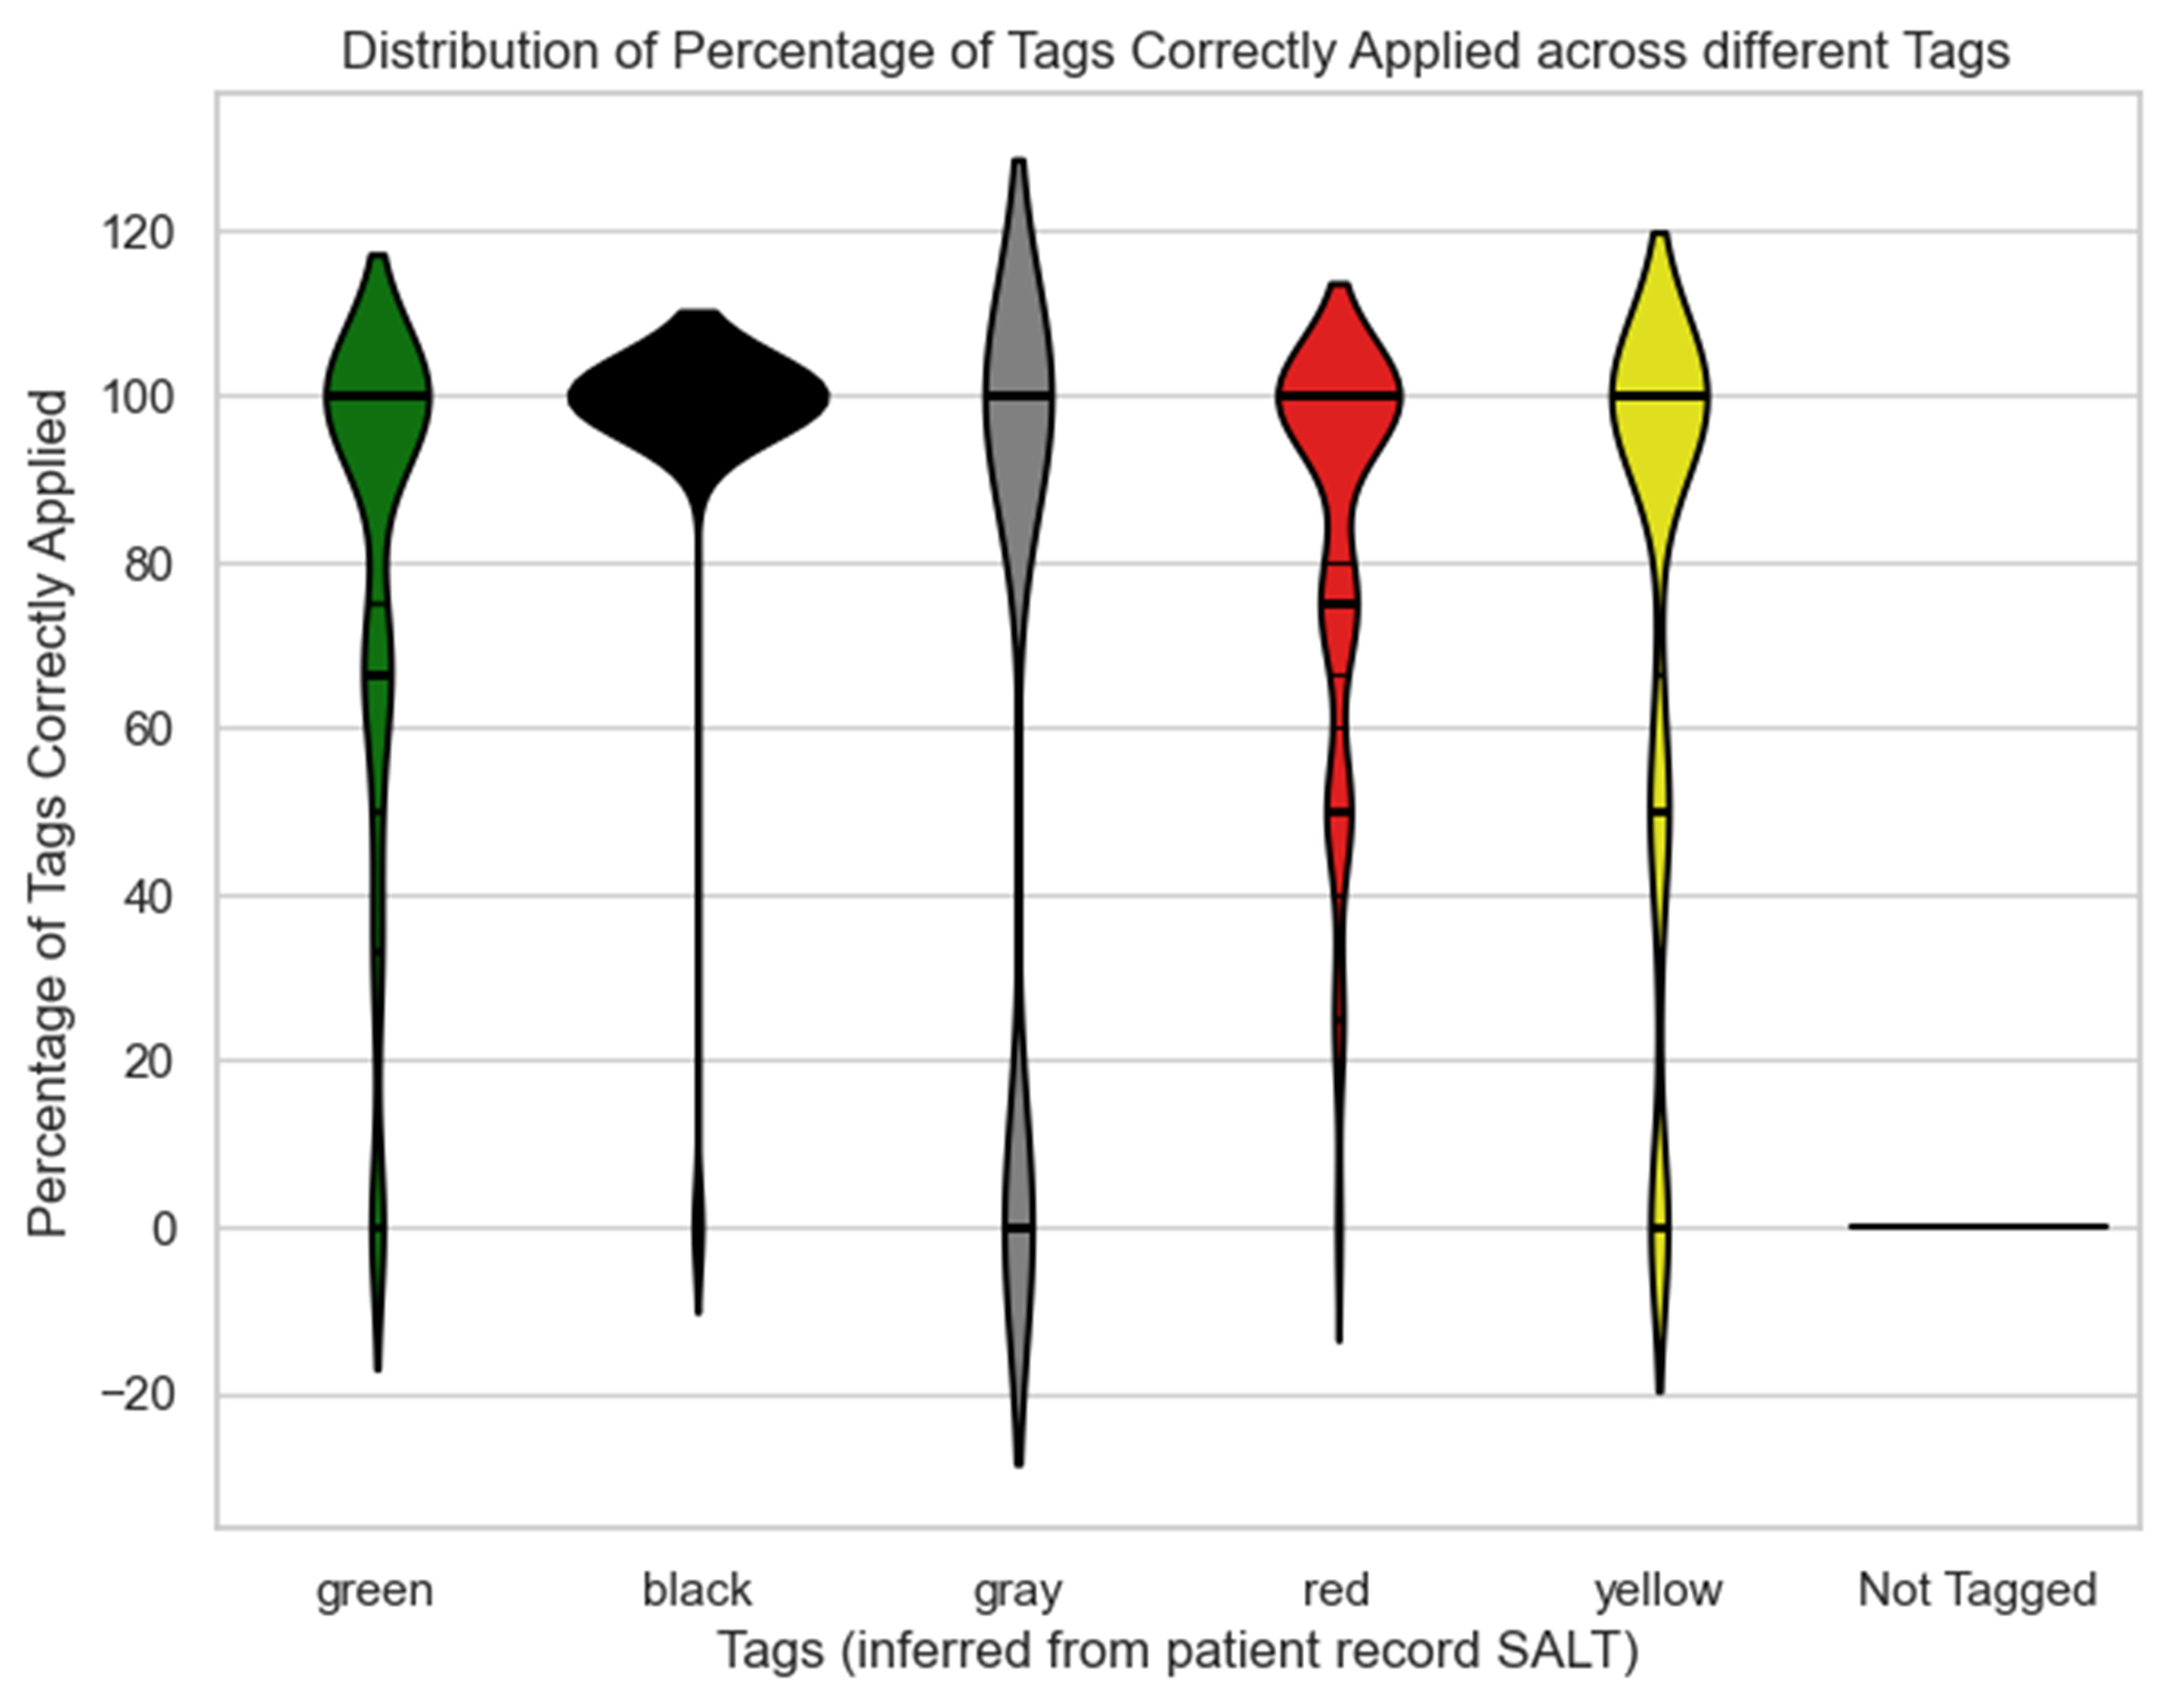

In [11]:

# Create the correct count data frame
correct_count_by_tag_df = fu.get_correct_count_by_tag_dataframe(tag_to_salt_df)

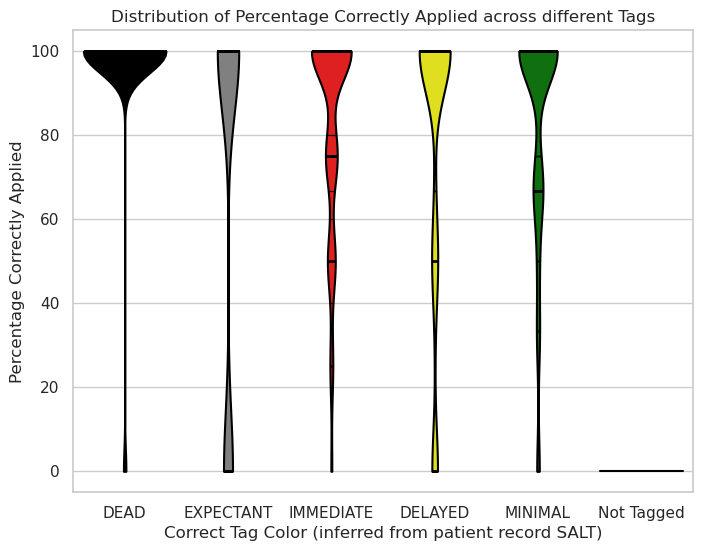

In [14]:

import seaborn as sns

# Sample data for the violin plot
data = {
    'predicted_tag': correct_count_by_tag_df.predicted_tag.tolist(),
    'percentage_tag_correct': correct_count_by_tag_df.percentage_tag_correct.tolist()
}

# Create a Data Frame from the data
df = DataFrame(data)

# Relabel tags as follows to match the triage error graph
df.predicted_tag = df.predicted_tag.replace({
    'black': 'DEAD',
    'gray': 'EXPECTANT',
    'green': 'MINIMAL',
    'red': 'IMMEDIATE',
    'yellow': 'DELAYED'
})

# Set the style of the plot
sns.set(style='whitegrid')

# Create the violin plot with 5 violins
plt.figure(figsize=(8, 6))
palette = ['white' if (color == 'Not Tagged') else color for color in correct_count_by_tag_df.predicted_tag.unique()]

# Make the scale from 0 to 100. This will cut off some of the violin plot
# but showing things above 100 or below 0 for a percentage does not make
# sense and will raise questions. I think it's trying to make the violin
# plot fit smoothly over values near 100 but that makes it go over 100.
# This is the same when you have ceiling effects for error bars.
sns.violinplot(x='predicted_tag', y='percentage_tag_correct', data=df, palette=palette, inner='stick', cut=0.0)

# Set plot labels and title
plt.xlabel('Correct Tag Color (inferred from patient record SALT)')
plt.ylabel('Percentage Correctly Applied')
plt.title('Distribution of Percentage Correctly Applied across different Tags')
# plt.ylim(0, 100)

# Show the plot
plt.show()


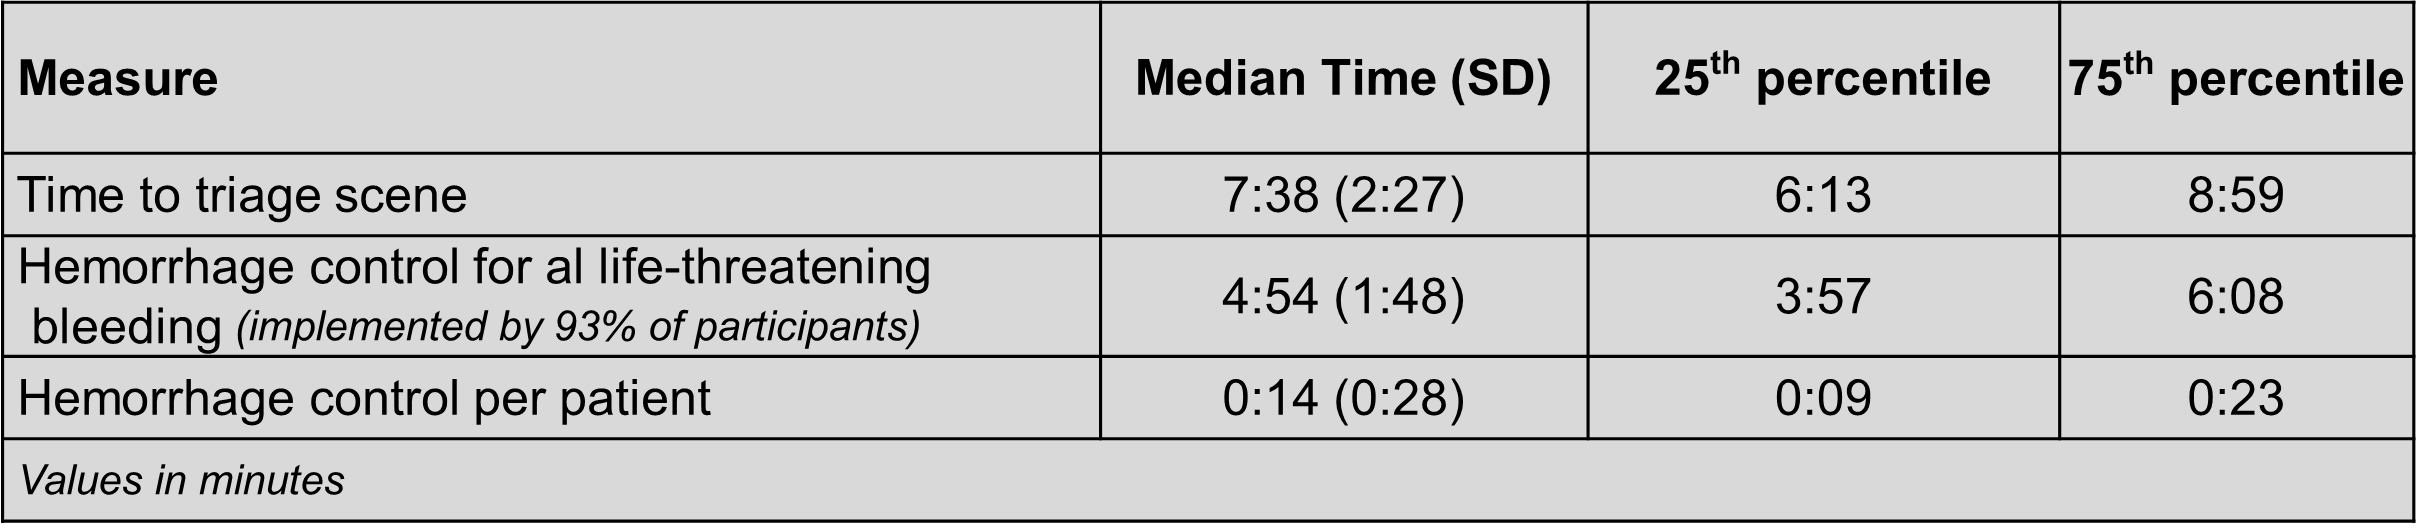

In [4]:

base_mask_series = (frvrs_logs_df.scene_type == 'Triage') & (frvrs_logs_df.is_scene_aborted == False)
base_mask_series &= (frvrs_logs_df.is_a_one_triage_file == True)

In [5]:

# Filter for patients with one PATIENT_ENGAGEMENT for each scene: .filter() causes the kernel to restart!
bad_sessions_set = set()
gb = frvrs_logs_df[base_mask_series].groupby(fu.patient_groupby_columns)
for (session_uuid, scene_id, patient_id), patient_df in gb:
    if fu.get_patient_engagement_count(patient_df) != 1:
        bad_sessions_set.add(session_uuid)
        continue
keys_mask_series = ~frvrs_logs_df.session_uuid.isin(bad_sessions_set)

In [6]:

# Get info for Time to triage scene row
cn = 'triage_time'
df = Series(
    [fu.get_triage_time(scene_df) for _, scene_df in frvrs_logs_df[keys_mask_series].groupby(fu.scene_groupby_columns)]
).to_frame().rename(columns={0: cn})
ttts_dict = nu.get_statistics(
    df, [cn]
).applymap(lambda x: fu.format_timedelta_lambda(timedelta(milliseconds=int(x)), minimum_unit='minutes'), na_action='ignore').to_dict()[cn]
ttts_dict

{'mean': '4:41', 'mode': '0:00', 'median': '5:13', 'SD': '3:32', 'min': '0:00', '25%': '0:47', '50%': '5:13', '75%': '7:16', 'max': '15:26'}

In [ ]:

# Get info for Hemorrhage control for all life-threatening bleeding note
keys_groups_count = len(frvrs_logs_df[keys_mask_series].groupby(fu.scene_groupby_columns).groups)
base_groups_count = len(frvrs_logs_df[base_mask_series].groupby(fu.scene_groupby_columns).groups)
percent_hemorrhage_controlled = 100 * keys_groups_count / base_groups_count
percent_hemorrhage_controlled # 59.430386337602826

In [8]:

# Get info for Hemorrhage control for all life-threatening bleeding row
cn = 'last_controlled_time'
df = Series([fu.get_time_to_last_hemorrhage_controlled(scene_df, verbose=False) for _, scene_df in frvrs_logs_df[keys_mask_series].groupby(
    fu.scene_groupby_columns
)]).to_frame().rename(columns={0: cn})
hcfaltb_dict = nu.get_statistics(df, [cn]).applymap(
    lambda x: fu.format_timedelta_lambda(timedelta(milliseconds=int(x)), minimum_unit='minutes'), na_action='ignore'
).to_dict()[cn]
hcfaltb_dict

{'mean': '3:11', 'mode': '0:00', 'median': '3:33', 'SD': '2:44', 'min': '0:00', '25%': '0:00', '50%': '3:33', '75%': '5:05', 'max': '12:43'}

In [9]:

# Get info for Hemorrhage control per patient
# Duration of time from when the patient was
# first approached by the participant until
# the time hemorrhage treatment was applied
# (with a tourniquet or wound packing)
cn = 'controlled_time'
times_list = []
for _, scene_df in frvrs_logs_df[keys_mask_series].groupby(fu.scene_groupby_columns):
    # scene_start = fu.get_scene_start(scene_df)
    for _, patient_df in scene_df.groupby('patient_id').filter(
        lambda patient_df: fu.get_patient_engagement_count(patient_df) == 1
    ).groupby('patient_id'):
        if fu.get_is_patient_hemorrhaging(patient_df):
            controlled_time = fu.get_time_to_hemorrhage_control(patient_df, scene_start=fu.get_first_patient_interaction(patient_df))
            times_list.append(controlled_time)
df = Series(times_list).to_frame().rename(columns={0: cn})
hcpp_dict = nu.get_statistics(df, [cn]).applymap(
    lambda x: fu.format_timedelta_lambda(timedelta(milliseconds=int(x)), minimum_unit='minutes'), na_action='ignore'
).to_dict()[cn]
hcpp_dict

{'mean': '0:13', 'mode': '0:00', 'median': '0:09', 'SD': '0:22', 'min': '0:00', '25%': '0:03', '50%': '0:09', '75%': '0:17', 'max': '4:30'}

In [10]:

from IPython.display import HTML

# Define a custom CSS class for the table
table_style = """
.custom-table {
    text-decoration: none;
    font-style: normal;
    color: black;
    white-space: normal;
}

.custom-table th {
    font-weight: 700;
    border: 1.5pt solid black;
    text-align: center;
    background: #D9D9D9;
    font-size: 24.0pt;
    font-family: Arial;
    vertical-align: middle;
}

.custom-table td {
    border: 1.5pt solid black;
    text-align: left;
    padding-right: 1px;
    padding-left: 1px;
    padding-top: 1px;
    background: #D9D9D9;
    font-size: 24.0pt;
    font-family: Arial;
}

.custom-table .italic-font {
    font-style: italic;
    font-size: 20.0pt;
}

.custom-table .colspan {
    colspan: 4;
}
"""

# Apply the custom CSS class to the table
html_str = f'''
<style>
{table_style}
</style>
<table class="custom-table">
    <tr height=48 style="border:'1.5pt solid black';height:36.0pt;">
        <th height=48 style="text-align:center;">Measure</th>
        <th style="text-align:center;">Median Time (SD)</th>
        <th style="text-align:center;">25<sup>th</sup> percentile</th>
        <th style="text-align:center;">75<sup>th</sup> percentile</th>
    </tr>
    <tr height=42 style="border-top:none;border:'1.5pt solid black';height:31.2pt;">
        <td height=42 style="text-align:left;">Time to triage scene</td>
        <td style="text-align:center;border-left:none;">{ttts_dict['median']} ({ttts_dict['SD']})</td>
        <td style="text-align:center;border-left:none;">{ttts_dict['25%']}</td>
        <td style="text-align:center;border-left:none;">{ttts_dict['75%']}</td>
    </tr>
    <tr height=42 style="border-bottom:none;border-top:'1.5pt solid black';border-right:'1.5pt solid black';border-top:none;height:31.2pt;">
        <td
            height=42 style="text-align:left;"
        >Hemorrhage control for all life-threatening bleeding<br /><span class="italic-font">(implemented by {percent_hemorrhage_controlled:.01f}% of participants)</span></td>
        <td style="text-align:center;border-bottom:'1.5pt solid black';">{hcfaltb_dict['median']} ({hcfaltb_dict['SD']})</td>
        <td style="text-align:center;border-bottom:'1.5pt solid black';">{hcfaltb_dict['25%']}</td>
        <td style="text-align:center;border-bottom:'1.5pt solid black';">{hcfaltb_dict['75%']}</td>
    </tr>
    <tr height=42 style="border-top:none;height:31.2pt;">
        <td height=42 style="text-align:left;">Hemorrhage control per patient</td>
        <td style="text-align:center;border-left:none;">{hcpp_dict['median']} ({hcpp_dict['SD']})</td>
        <td style="text-align:center;border-left:none;">{hcpp_dict['25%']}</td>
        <td style="text-align:center;border-left:none;">{hcpp_dict['75%']}</td>
    </tr>
    <tr height=42>
        <td
            colspan=4 height=42 style="border-bottom:'1.5pt solid black';border-top:'1.5pt solid black';border-right:'1.5pt solid black';height:31.2pt;text-align:left;border-left:'1.5pt solid black';"
        ><span class="italic-font">Values in minutes</span></td>
    </tr>
</table>'''
with open('../saves/html/sdmph_poster_measures_table.html', 'w') as f: f.write(html_str)
HTML(html_str)


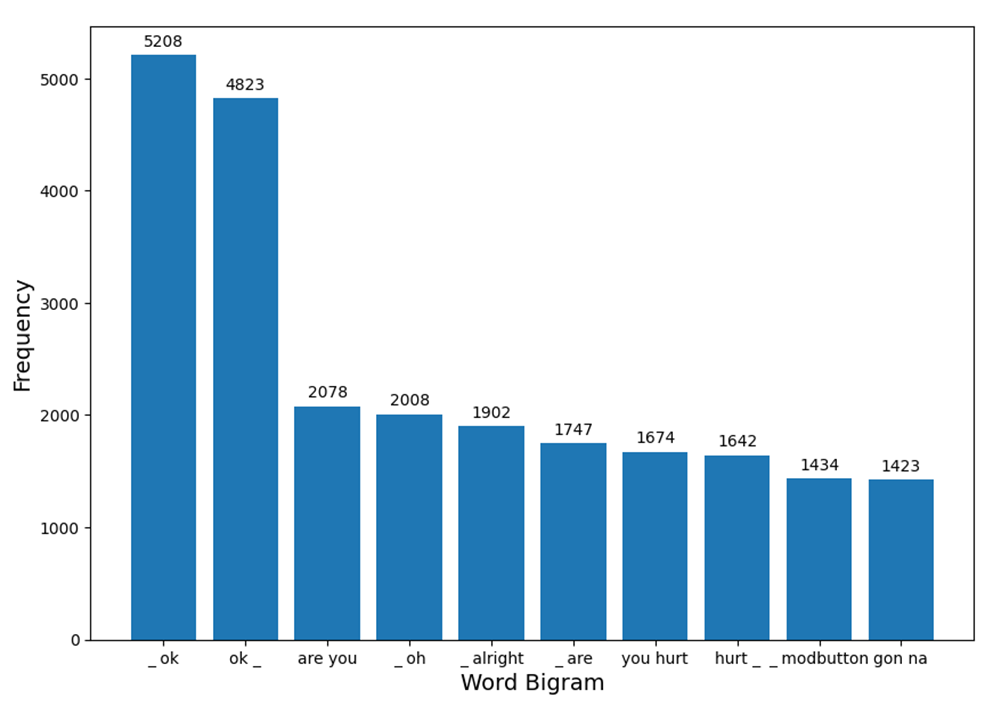

In [ ]:

def ultimate_tokenize(sentence):
    
    # Remove punctuation and digits
    sentence = sentence.translate(str.maketrans('', '', string.punctuation + string.digits))
    
    return word_tokenize(sentence.lower())

In [ ]:

from nltk import ngrams, FreqDist, word_tokenize

mask_series = (frvrs_logs_df.action_type == 'VOICE_CAPTURE')
df = frvrs_logs_df[mask_series]
voice_capture_tokens_words = [ultimate_tokenize(x) for x in df.voice_capture_message]
voice_capture_tokens_words_trigrams = [
    list(
        ngrams(x, 3, pad_left=False, pad_right=False, left_pad_symbol='_', right_pad_symbol='_')
    ) for x in voice_capture_tokens_words
]
for x in voice_capture_tokens_words_trigrams[0]:
    print(x)

In [ ]:

trigram_freqdists_list = [FreqDist(x) for x in voice_capture_tokens_words_trigrams]
for freqdist_obj in trigram_freqdists_list:
    freqdist_obj.pprint()
    break

In [ ]:

trigram_dict = dict()
for freqdist_obj in trigram_freqdists_list:
    for k, v in freqdist_obj.items():
        k = ' '.join(k)
        if k in trigram_dict: v += trigram_dict[k]
        trigram_dict[k] = v

# Display a sub-dictionary with a number of random keys and their values
nu.get_random_subdictionary(trigram_dict)

In [ ]:

import operator

trigram_freqs = sorted(trigram_dict.items(), key=operator.itemgetter(1), reverse=True)
trigram_freqs[:10]

In [ ]:

from numpy import arange

labels, values = zip(*trigram_freqs[:10])
indices = arange(len(labels))
width = 0.8 # width = 1 would give bars that overlap because they are too close

fig = plt.figure(figsize=(10,7))                                                               
ax = fig.gca() # Get current axis
rects = ax.bar(indices, values, width)

# Add title and axis labels
fig.suptitle('Top 10 Word Trigrams', fontsize=20)
plt.xlabel('Word Trigram', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.ylim(0, 1_800)

# Display value of each bar on bar
for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 50 + height, '%d' % int(height), ha='center', va='bottom') # Can also add color and fontweight arguments.

# Remove the default x-axis tick numbers and use tick numbers of your own choosing
ax.set_xticks(indices)

# Replace the tick numbers with strings
ax.set_xticklabels(labels, rotation=45)

plt.show()
# plt.savefig('top10EnglishWordTrigrams.png')


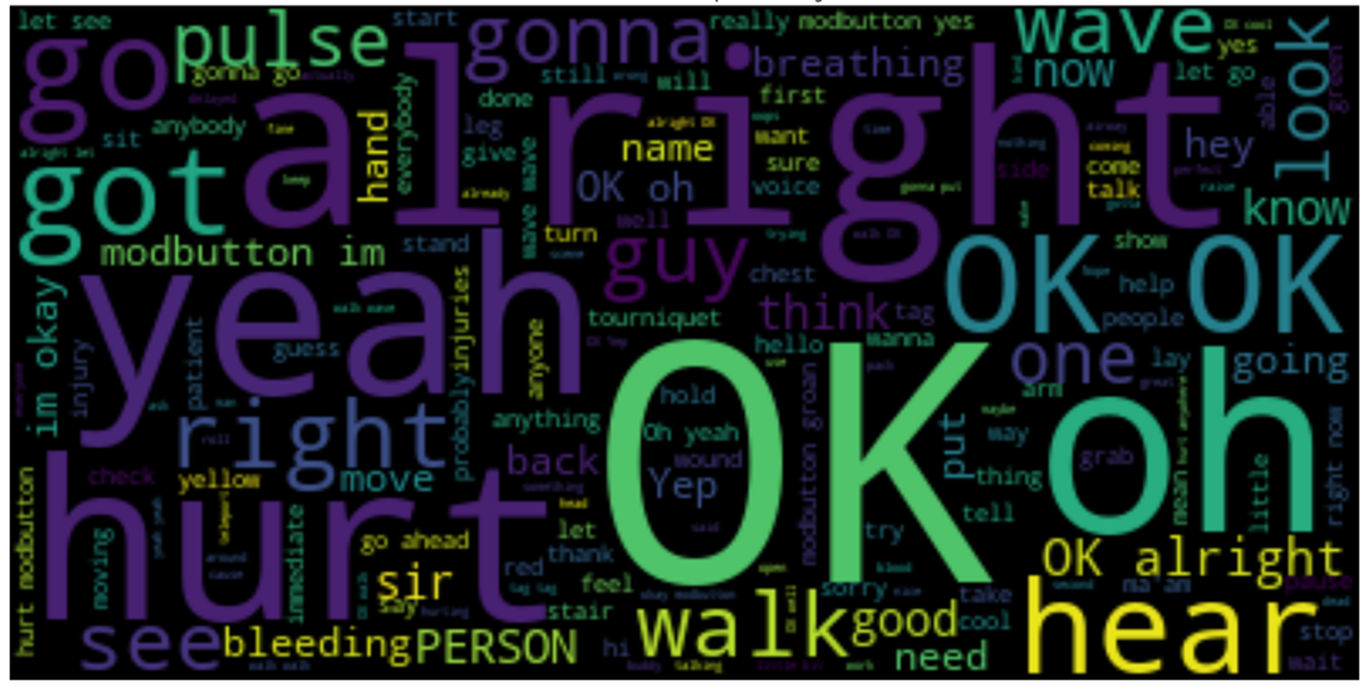

In [ ]:

from wordcloud import WordCloud

# Flatten the list of lists of words
mask_series = (frvrs_logs_df.action_type == 'VOICE_CAPTURE')
voice_capture_words_list_list = frvrs_logs_df[mask_series].voice_capture_message.tolist()
voice_capture_words_list = []
for voice_capture_words in voice_capture_words_list_list: voice_capture_words_list += voice_capture_words.split()

# Create a word cloud object
wordcloud = WordCloud(max_font_size=100, max_words=200, background_color='white').generate(' '.join(voice_capture_words_list))

# Plot the word cloud
plt.figure(figsize=(18, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title('Word Cloud of Voice Capture Messages')
plt.show()